# Modules

In [1]:
%load_ext autoreload
%autoreload 2

import os
import subprocess
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

%aimport cnv_inference_config
project_config = cnv_inference_config
os.chdir(project_config.MB_ROOT)

from collections import Counter, defaultdict, OrderedDict
import multiprocessing as mp
import pickle

from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

from data_types import ase
from classification.models.mle_classifier import AseMleClassifier
import toolkit
import util
from workspace.workspace_manager import WorkspaceManager

sns.set()

workspace = {}
for data_type in ["scDNA", "scRNA"]:
    workspace.update({ 
        data_type : WorkspaceManager(
            task_name="ase_to_cnv",
            experiment_info={"data" : data_type},
            verbose=True
        )
    })
    workspace[data_type].load_workspace()

# Loading workspace

In [2]:
clustering_tag = {
    "scDNA" : "evo_dist_9_eb",
    "scRNA" : "none"
}
# filtering_tag = "PC1_PC2_90%"
data = {}
for data_type in ["scDNA", "scRNA"]:
    data[data_type] = {
        data_name :
        util.pickle_load(data_dump)
        for data_name, data_dump in tqdm_notebook(
            workspace[data_type].tmp_data.items(),
            f"{data_type}, loading datasets into RAM"
        )
    }

In [4]:
workspace["scDNA"]

Task name: ase_to_cnv
Experiment info:
{
    "data": "scDNA",
    "sample": "STP_G&T"
}
Config generated on 2019-10-31 01:03
Contents:
{
    "task_name": "ase_to_cnv",
    "experiment_info": {
        "data": "scDNA",
        "sample": "STP_G&T"
    },
    "cookiecutter_info": {
        "root": "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference",
        "lib": "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/lib",
        "notebooks": "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/notebooks",
        "src": "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/src",
        "tests": "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/tests",
        "img": "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/img",
        "data": "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data",
        "raw": "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/raw",
        "tmp": "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/tmp",
        "processed": "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/processed"
    },
    "config_dir": "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/notebooks/ase_to_cnv",
    "data_dir": {
        "root": "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/processed",
        "sample": "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/processed/STP_G&T/scDNA"
    },
    "data": {
        "block_counts": "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/processed/STP_G&T/scDNA/block_counts.pkl",
        "clustering": "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/processed/STP_G&T/scDNA/evo_dist_9_eb_clustering.pkl"
    },
    "tmp_data_dir": {
        "root": "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/tmp/ase_to_cnv",
        "sample": "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/tmp/ase_to_cnv/STP_G&T/scDNA"
    },
    "tmp_data": {
        "block_counts": "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/tmp/ase_to_cnv/STP_G&T/scDNA/block_counts.pkl",
        "clustering": "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/tmp/ase_to_cnv/STP_G&T/scDNA/clustering.pkl"
    },
    "img_dir": {
        "root": "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/img/ase_to_cnv",
        "sample": "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/img/ase_to_cnv/STP_G&T"
    }
}

# Runtime

In [63]:
%%time

ase_info = {
#     "scDNA" : pd.DataFrame(toolkit.extract_counts(
#         toolkit.aggregate_by_barcode_groups(
#             data["scDNA"]["block_counts"],
#             data["scDNA"]["clustering"]
#         ),
#         suffix="ad"
#     ).values / \
#     toolkit.extract_counts(
#         toolkit.aggregate_by_barcode_groups(
#             data["scDNA"]["block_counts"],
#             data["scDNA"]["clustering"]
#         )
#     ).values, columns=[str(i+1) for i in np.arange(9)]),
    "scDNA" : pd.DataFrame(toolkit.extract_counts(
        data["scDNA"]["block_counts"],
        suffix="ad"
    ).values / \
    toolkit.extract_counts(
        data["scDNA"]["block_counts"]
    ).values, columns=[str(i+1) for i in np.arange(96)]),
    "scRNA" : pd.DataFrame(toolkit.extract_counts(
        data["scRNA"]["block_counts"],
        suffix="ad"
    ).values / \
    toolkit.extract_counts(
        data["scRNA"]["block_counts"]
    ).values, columns=[str(i+1) for i in np.arange(96)])
    #{ "scDNA" : data["scDNA"]["ase"] }
}
block_counts_info = {
    data_type : data[data_type]["block_counts"]
    for data_type in workspace.keys()
}

# clustering_info = {
#     data_type : data[data_type]["clustering"]
#     for data_type in workspace.keys()
# }
block_counts_info["scDNA"]["BLOCK_ID"]= block_counts_info["scDNA"]["BLOCK_ID"].astype(str)
block_counts_info["scRNA"]["BLOCK_ID"]= block_counts_info["scRNA"]["BLOCK_ID"].astype(str)
ase_info["scDNA"]["BLOCK_ID"] = block_counts_info["scDNA"]["BLOCK_ID"]

common_blocks = (set(block_counts_info["scDNA"]["BLOCK_ID"]) 
                & set(block_counts_info["scRNA"]["BLOCK_ID"]))

print("Datasets have {} blocks in common".format(len(common_blocks)))

ase_info["scDNA"] = util.filter_by_isin(
    ase_info["scDNA"], 
    "BLOCK_ID", 
    common_blocks
).reset_index(drop=True)

for data_type in workspace.keys():
    block_counts_info[data_type] = util.filter_by_isin(
        block_counts_info[data_type], 
        "BLOCK_ID", 
        common_blocks
    ).reset_index(drop=True)
    
assert block_counts_info["scRNA"].shape[0] == block_counts_info["scDNA"].shape[0]

Datasets have 10715 blocks in common
CPU times: user 115 ms, sys: 45.9 ms, total: 161 ms
Wall time: 158 ms


/icgc/dkfzlsdf/analysis/B260/users/v390v/.conda/envs/xclone/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


In [33]:
dp_per_cell = toolkit.extract_counts(block_counts_info["scRNA"]).sum(axis=0)
pd.DataFrame(dp_per_cell.describe(percentiles=0.1 + np.arange(0, 1, 0.1)))

,0
count,96.00000
mean,28157.68750
std,48036.55348
min,81.00000
10%,2114.50000
20%,4006.00000
30%,6933.50000
40%,10856.00000
50%,14250.50000
60%,20158.00000


In [34]:
nonzero_dp_per_cell = (toolkit.extract_counts(block_counts_info["scRNA"]) > 0).sum(axis=0)
pd.DataFrame(nonzero_dp_per_cell.describe(percentiles=0.1 + np.arange(0, 1, 0.1)))

,0
count,96.000000
mean,1381.291667
std,962.067422
min,65.000000
10%,379.500000
20%,710.000000
30%,956.500000
40%,1104.000000
50%,1224.000000
60%,1360.000000


In [66]:
missing_barcodes = np.setdiff1d(
    toolkit.extract_barcodes(block_counts_info["scRNA"]),
    data["scDNA"]["clustering"]["BARCODE"]
)
missing_barcodes.size

7

In [67]:
block_counts_info["scDNA"].drop(
    columns=[f"{barcode}_ad" for barcode in missing_barcodes],
    inplace=True
)
block_counts_info["scDNA"].drop(
    columns=[f"{barcode}_dp" for barcode in missing_barcodes],
    inplace=True
)
block_counts_info["scRNA"].drop(
    columns=[f"{barcode}_ad" for barcode in missing_barcodes],
    inplace=True
)
block_counts_info["scRNA"].drop(
    columns=[f"{barcode}_dp" for barcode in missing_barcodes],
    inplace=True
)

In [56]:
assert np.all(np.isin(
    toolkit.extract_barcodes(block_counts_info["scRNA"]),
    data["scDNA"]["clustering"]["BARCODE"]
))

In [68]:
%%time
clf = AseMleClassifier(ase_info["scDNA"].drop(columns=["BLOCK_ID"]))
# clustered_scRNA_counts_df = toolkit.aggregate_by_barcode_groups(
#     gene_counts_info["scRNA"],
#     clustering_info["scRNA"],
#     verbose=True
# )


labels = clf.predict(block_counts_info["scRNA"])#clustered_scRNA_counts_df)
print(f"{np.unique(labels).size} clusters detected")

# clf.classification_report(
#     clustering_info["scRNA"].LABEL.apply(lambda i: labels[i] + 1), 
#     title=f"MLE label assignment, {filtering_tag}\n"
#             f"{clustering_tag['scDNA']} clustering of scDNA,\n"
#             f"{clustering_tag['scRNA']} clustering of scRNA,\n"
#             f"{gene_counts_info['scRNA'].shape[0]} genes",
#     outfile=f"{workspace['scRNA'].img_dir}"
#             f"/{filtering_tag}_{clustering_tag['scDNA']}"
#             f"_{clustering_tag['scRNA']}_MLE_labels.pdf"
    
# )

3 clusters detected
CPU times: user 35.1 s, sys: 2.43 ms, total: 35.1 s
Wall time: 35.1 s


In [70]:
labels

array(['10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10',
       '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10',
       '10', '10', '10', '10', '10', '10', '10', '23', '10', '10', '10',
       '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '23',
       '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10',
       '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10',
       '23', '23', '10', '10', '10', '23', '10', '10', '10', '10', '23',
       '69', '10', '10', '10', '10', '10', '10', '10', '23', '10', '10',
       '10'], dtype='<U2')

In [ ]:
data["scDNA"]["clustering"]["LABEL"]

In [69]:
(labels == data["scDNA"]["clustering"]["LABEL"]).mean()

0.0

In [19]:
nan_freq_and_counts = pd.concat(
    [gene_counts_info["scRNA"].isna().mean(axis=0), 
     gene_counts_info["scRNA"].sum(axis=0)],
    axis=1
).drop("GENE_ID").values

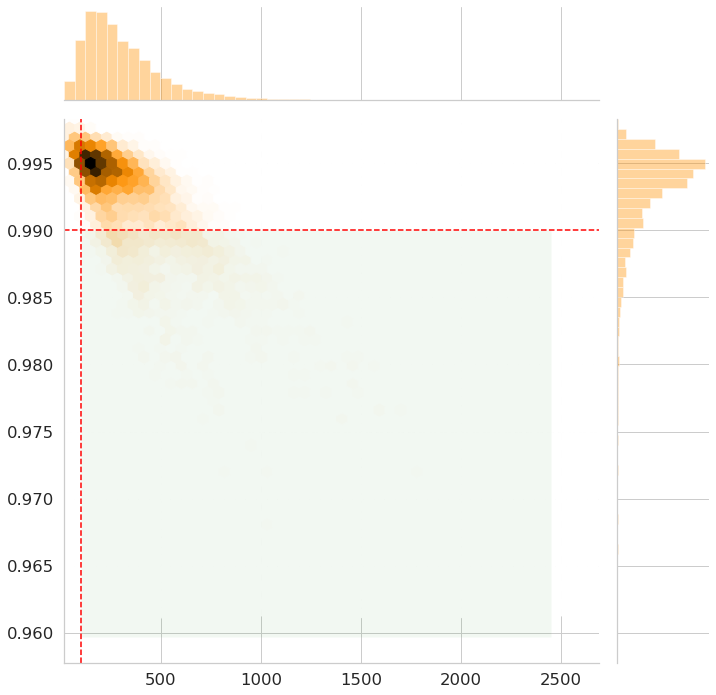

In [20]:
# fig, ax = plt.subplots(figsize=(20,10))
g = sns.jointplot(
    nan_freq_and_counts[:, 1],
    nan_freq_and_counts[:, 0],    
    kind="hex",
    color="xkcd:tangerine",
    height=10
)
g.ax_joint.axhline(0.99, color="red", linestyle="--")
g.ax_joint.axvline(100, color="red", linestyle="--")
y_min, y_max = g.ax_joint.get_ylim()
g.ax_joint.fill_between(
    np.arange(100, 2500, 50), y_min, 0.99,
    facecolor='green', alpha=0.05
)

In [21]:
np.median(nan_freq_and_counts[:,0])

0.9938468550592525

In [22]:
np.median(nan_freq_and_counts[:,1])

262.0

In [23]:
filtering_tag = "no_filtering"

In [24]:
def classification_report(labels, title, outfile=None):
        sns.set(style="whitegrid", font_scale=1.5)
        fig, ax = plt.subplots(2, 1, figsize=(20,25))
        ax[0].set_title("Cluster label assigned by MLE", fontsize=20)
        sns.countplot(
            labels, 
            palette=sns.color_palette("muted", 
                                      n_colors=np.unique(labels).size),
#             {
#                 1 : "#3182bd", #"C0",
#                 2 : "#2ca25f", #"C2",
#                 3 : "#feb24c"#"C1"
#             },
            ax=ax[0]
        )
        
        sns.set(style="whitegrid", font_scale=1.5);
    
        ax[1].set_title(title)
        
        sns.scatterplot(
            x="TSNE_1", y="TSNE_2", 
            hue=labels, 
            data=clustering_info["scRNA"], 
            legend="full",
            palette=sns.color_palette("muted", 
                                      n_colors=np.unique(labels).size),
#             {
#                 1 : "#3182bd", #"C0",
#                 2 : "#2ca25f", #"C2",
#                 3 : "#feb24c"#"C1"
#             },
            ax=ax[1]
        );
        ax[1].legend().get_frame().set_facecolor("white");
        ax[1].legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left")
        fig.subplots_adjust(right=0.75)
        if outfile is not None:
            fig.savefig(outfile, format=outfile.split('.')[-1], dpi=300)


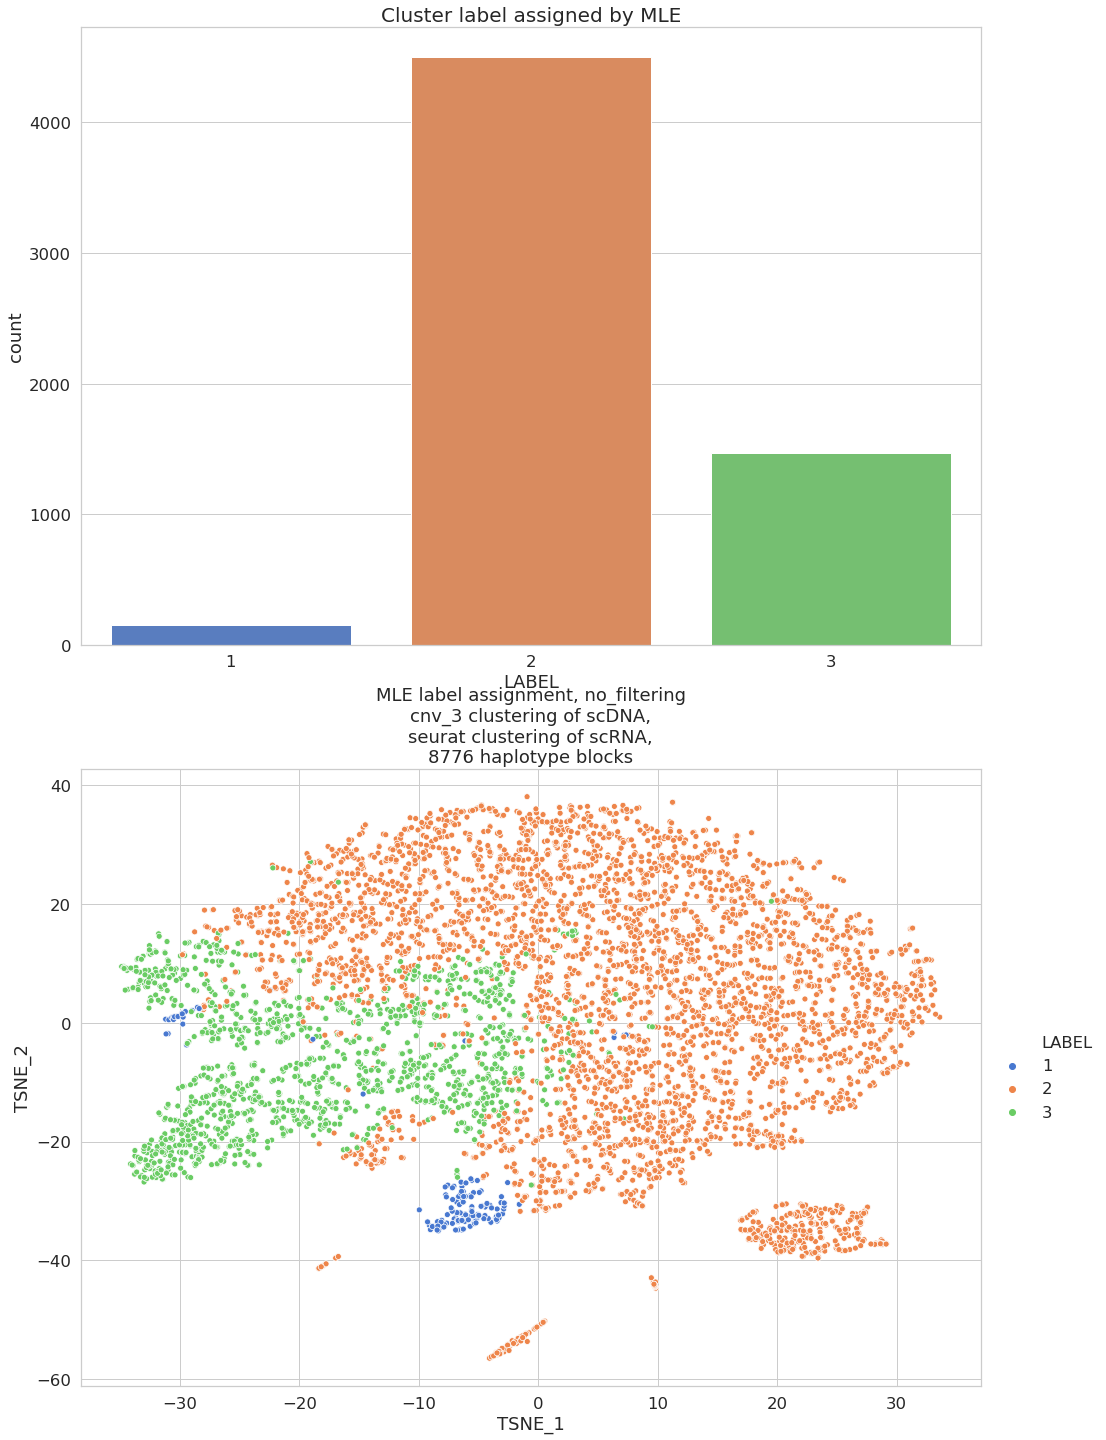

In [25]:
classification_report(
    clustering_info["scRNA"].LABEL.apply(lambda i: labels[i]),#labels,
    title=f"MLE label assignment, {filtering_tag}\n"
            f"{clustering_tag['scDNA']} clustering of scDNA,\n"
            f"{clustering_tag['scRNA']} clustering of scRNA,\n"
            f"{gene_counts_info['scRNA'].shape[0]} haplotype blocks",
    outfile=f"{workspace['scRNA'].img_dir}"
            f"/{filtering_tag}_{clustering_tag['scDNA']}"
            f"_{clustering_tag['scRNA']}_MLE_labels.pdf"
)